Read two documents and integrate data using 'parent_asin'. Select 11 variables and filter for the "Appliances" category from all classes. Additionally, select only reviews with verified payments to avoid fake reviews.

Data praparing

Topic model Method 1

In [7]:
# Method 1 TF-IDF + LDA  + SBERT
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

verified_review = pd.read_csv('/Users/apple/Desktop/Business Project/data/pre_progress_data.csv')
# Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5)
tfidf = tfidf_vectorizer.fit_transform(verified_review['processed_text'])

# Fit the LDA model
n_components = 7  # Assume extracting 7 topics
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, random_state=42)
lda.fit(tfidf)

# Extract keywords for each topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

no_top_words = 15
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
topics = display_topics(lda, tfidf_feature_names, no_top_words)

# Convert extracted keywords to DataFrame
topics_df = pd.DataFrame(topics)

# Print extracted keywords
print(topics_df)

# Or display the extracted keywords DataFrame
topics_df





              0        1          2          3             4          5  \
0          part      ice      great  excellent        filter  described   
1   replacement     love       work    product         water      stove   
2           fit      use       good    quality          like       look   
3         dryer     make        fit       nice         taste       hood   
4       perfect    maker    perfect      thank  refrigerator         ok   
5          easy    great    install    problem          work      range   
6         exact    small       easy   delivery         price        fit   
7      original  machine     worked      happy         great       work   
8         right     easy    product    service          much    looking   
9     perfectly  freezer  perfectly       good          good       nice   
10      install     work      price       fast        better      great   
11          one     size       well      great         brand      light   
12          new   little 

,0,1,2,3,4,5,6
0,part,ice,great,excellent,filter,described,one
1,replacement,love,work,product,water,stove,get
2,fit,use,good,quality,like,look,work
3,dryer,make,fit,nice,taste,hood,washer
4,perfect,maker,perfect,thank,refrigerator,ok,month
5,easy,great,install,problem,work,range,dryer
6,exact,small,easy,delivery,price,fit,water
7,original,machine,worked,happy,great,work,time
8,right,easy,product,service,much,looking,working
9,perfectly,freezer,perfectly,good,good,nice,clothes


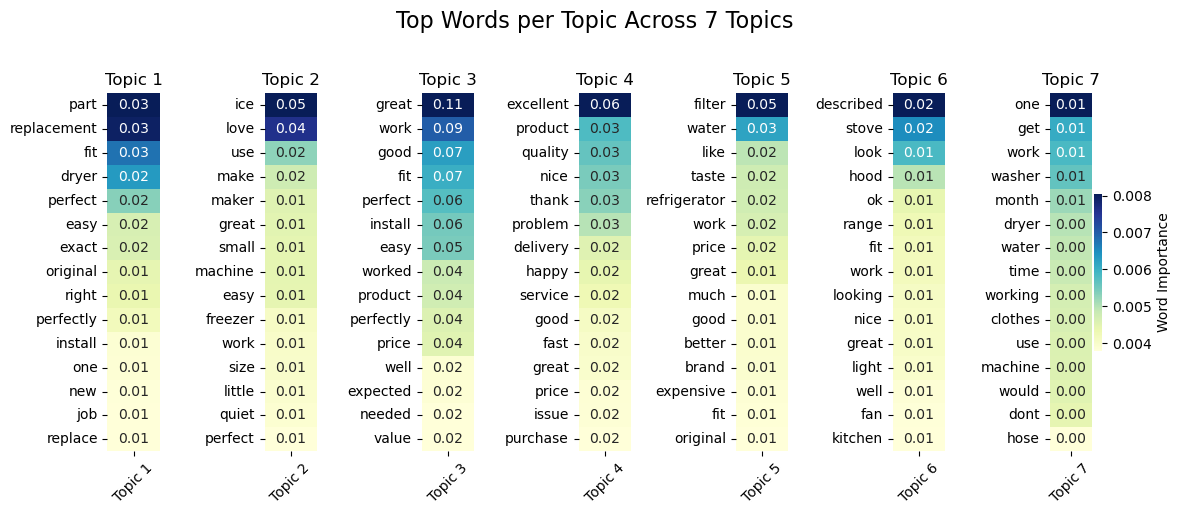

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation




# Extract keywords and their distribution
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_word_distribution = np.array([row / row.sum() for row in lda.components_])
num_top_words = 15

# Create a figure and subplots, set up a single row with multiple columns
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(12, 5))  

# Title to the figure
fig.suptitle('Top Words per Topic Across 7 Topics', fontsize=16, y=1.02)  

# For each topic, extract data and plot a heatmap
for i in range(7):
    data = {f'Topic {i+1}': topic_word_distribution[i]}
    df = pd.DataFrame(data, index=feature_names)
    df = df.sort_values(by=f'Topic {i+1}', ascending=False).head(num_top_words)

   
    show_cbar = i == 6  
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap='YlGnBu', cbar=show_cbar, ax=axes[i])
    axes[i].set_title(f'Topic {i+1}')
    axes[i].tick_params(axis='x', rotation=45) 


    if show_cbar:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Word Importance')


plt.tight_layout()
plt.show()

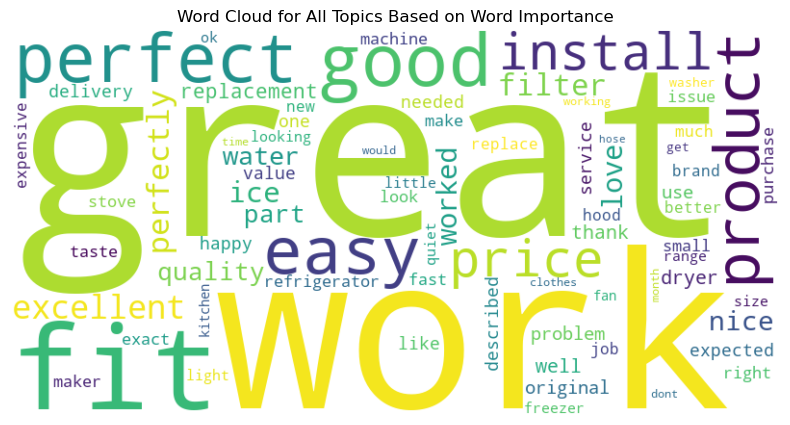

In [9]:
# WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

num_top_words = 15

word_weights = {}
for topic_idx, topic in enumerate(topic_word_distribution):
    for i in topic.argsort()[-num_top_words:][::-1]:  
        word = feature_names[i]
        weight = topic[i]
        if word in word_weights:
            word_weights[word] += weight 
        else:
            word_weights[word] = weight 

# Plot
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_weights)

# Show
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for All Topics Based on Word Importance")
plt.axis("off")
plt.show()



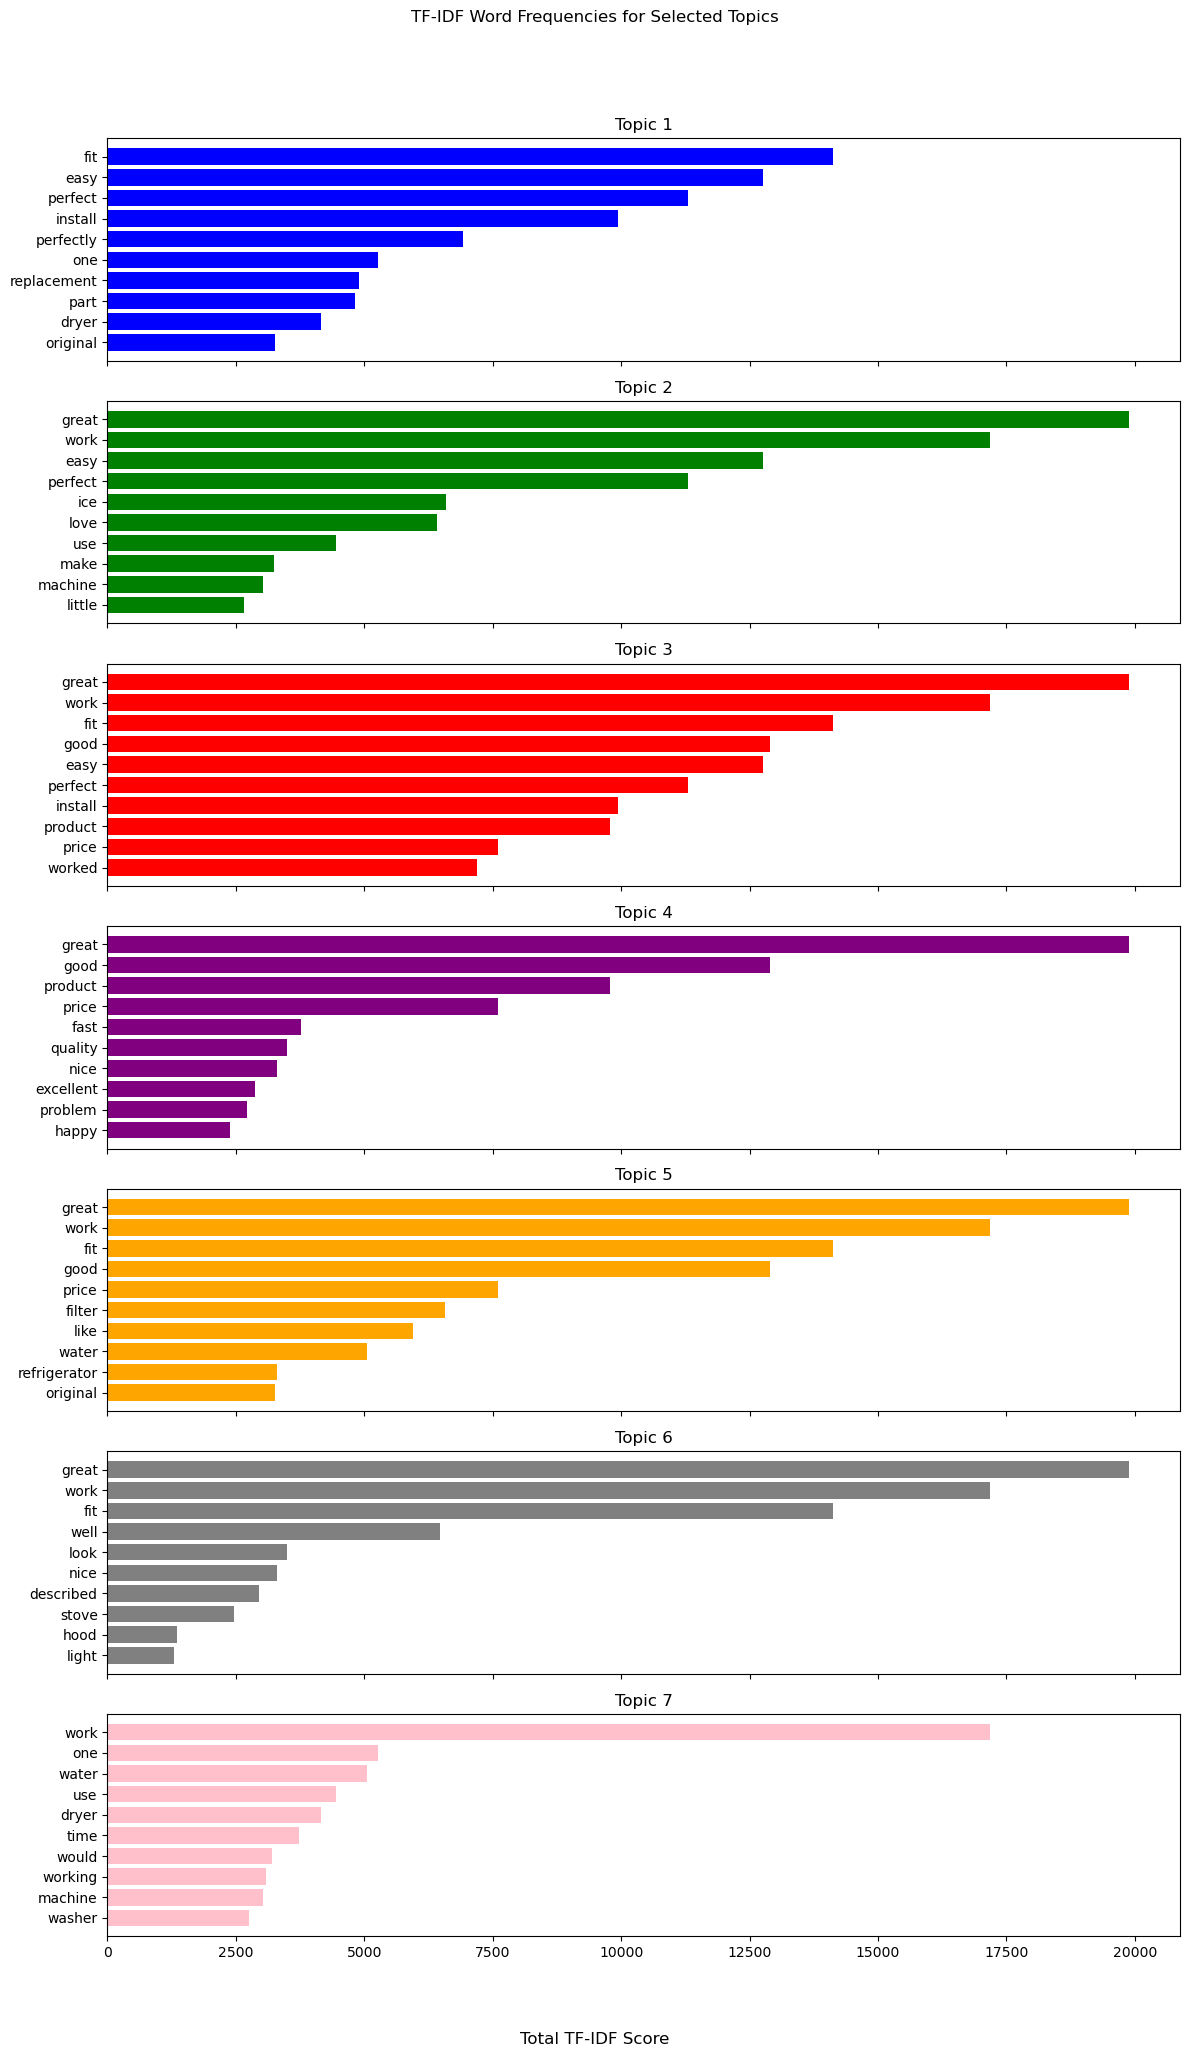

In [10]:
# Function to plot TF-IDF word frequency
def plot_tfidf_word_frequency(vectorizer, tfidf_result, topics_df, no_of_terms=10):
    # Calculate the sum of TF-IDF scores for each term across all documents
    sums = tfidf_result.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    
    # Set up colors for the topics
    colors = ['blue', 'green', 'red', 'purple', 'orange','gray','pink']
    fig, axes = plt.subplots(len(topics_df.columns), 1, figsize=(12, 3 * len(topics_df.columns)), sharex=True)
    if len(topics_df.columns) == 1:
        axes = [axes]
    
    for i, topic in enumerate(topics_df.columns):
        terms = topics_df[topic]
        subset = ranking[ranking['term'].isin(terms)].sort_values('rank', ascending=False)[:no_of_terms]
        axes[i].barh(subset['term'], subset['rank'], color=colors[i % len(colors)])
        axes[i].set_title(f'Topic {i+1}')
        axes[i].invert_yaxis()
    
    fig.suptitle("TF-IDF Word Frequencies for Selected Topics")
    fig.supxlabel("Total TF-IDF Score")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_tfidf_word_frequency(tfidf_vectorizer, tfidf, topics_df, 10)

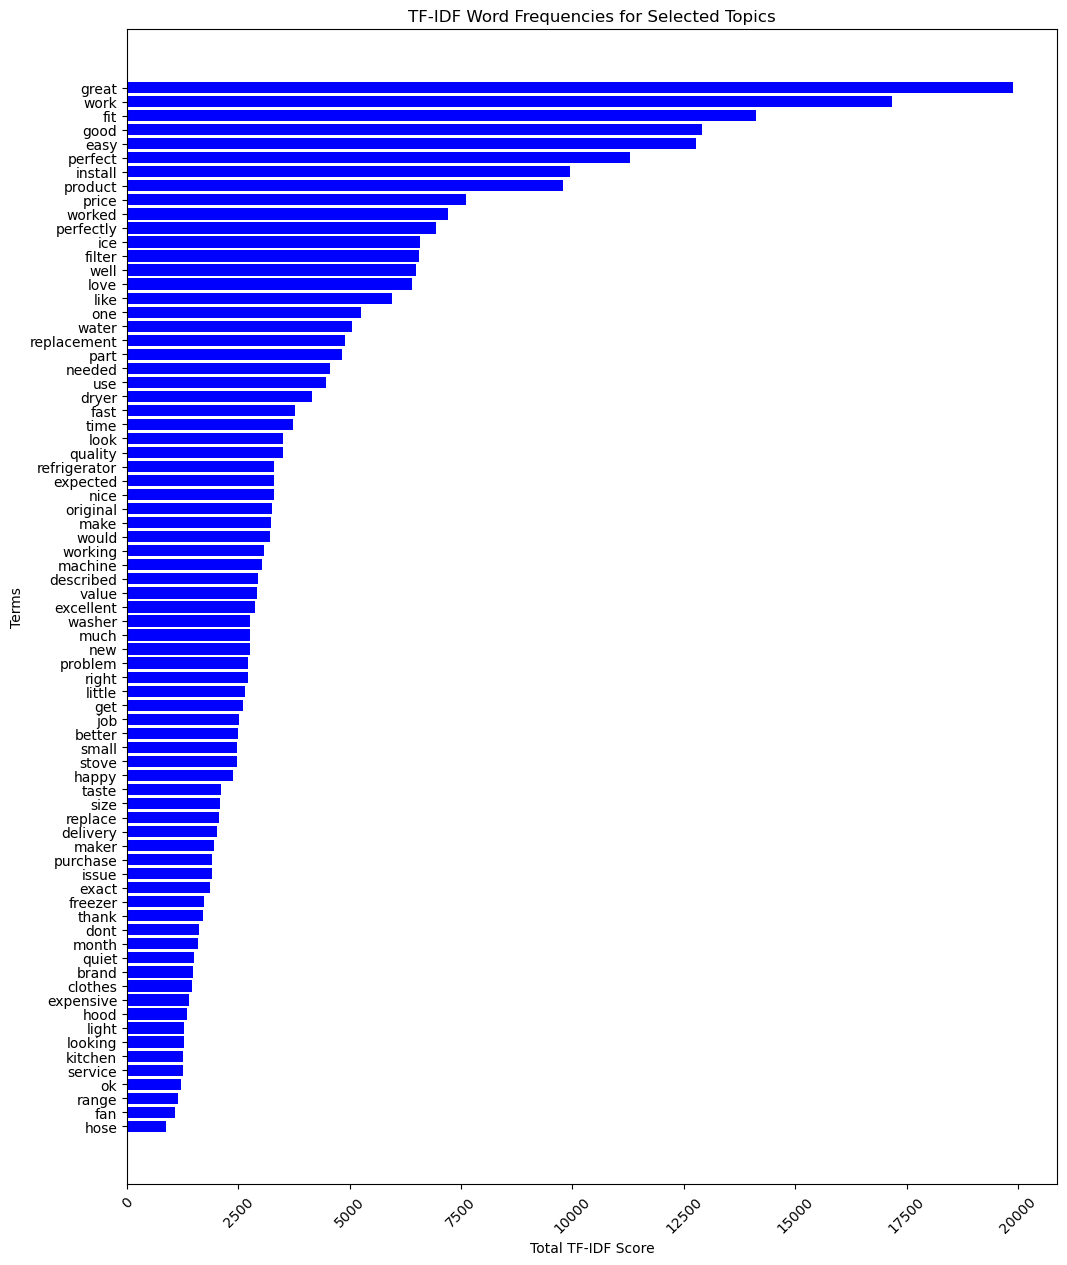

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_tfidf_word_frequency(vectorizer, tfidf_result, topics_df):
    # Calculate the sum of TF-IDF scores for each term across all documents
    sums = tfidf_result.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    
    # Extract all terms from topics_df
    terms = topics_df.values.flatten()
    # Filter the TF-IDF values for these terms
    filtered_ranking = ranking[ranking['term'].isin(terms)]
    filtered_ranking = filtered_ranking.sort_values('rank', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 15))
    plt.barh(filtered_ranking['term'], filtered_ranking['rank'], color='blue')
    plt.gca().invert_yaxis() 
    plt.xticks(rotation=45)
    plt.title("TF-IDF Word Frequencies for Selected Topics")
    plt.xlabel("Total TF-IDF Score")
    plt.ylabel("Terms")
    plt.show()


plot_tfidf_word_frequency(tfidf_vectorizer, tfidf, topics_df)
